<a href="https://colab.research.google.com/github/wmueri13/etsp_project_2022/blob/main/ETSP_Project_Predict_Stock_Momentum_by_News_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Stock Momentum by News Article Text (SequenceClassification)


## Installs & Downloads

In [ ]:
! pip install transformers
! pip install datasets
! pip install scipy sklearn
! pip install huggingface_hub
! pip install evaluate
! pip install git
! pip install apt
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.2 MB/s 
     |████████████████████████████████| 163 kB 63.7 MB/s 
     |████████████████████████████████| 7.6 MB 40.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 5.2 MB/s 
     |████████████████████████████████| 212 kB 53.6 MB/s 
     |████████████████████████████████| 115 kB 52.8 MB/s 
     |████████████████████████████████| 127 kB 67.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=aff011a4b4edf4794350ccd201d5aeff1ca5107bd277df171ad7

In [ ]:
! pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import transformers

print(transformers.__version__)

4.23.1


In [ ]:
model_checkpoint = "distilbert-base-uncased"
batch_size = 32 # 2 to 32 ########################################################################

## Loading the news and stock datasets

In [ ]:
import time
import calendar
import json

# Get loaded JSON data
news_history = None
price_daily = None
with open('news_history.json', 'r') as file:
  news_history = json.load(file)
with open('price_daily.json', 'r') as file:
  price_daily = json.load(file)

# Epoch-to-date function from miliseconds since epoch (int) to yyyy-mm-dd (str)
def epoch_to_date(seconds):
    seconds = int(seconds / 1000)
    lst = list(time.gmtime(seconds))
    year = str(lst[0])
    month = str(lst[1])
    if len(month) == 1: month = '0'+str(month)
    day = str(lst[2])
    if len(day) == 1: day = '0'+str(day)
    res = str(year)+'-'+str(month)+'-'+str(day)
    assert len(res) == 10, 'Date does not have the correct format len='+str(len(res))
    return res

# Date-to-epoch function from yyyy-mm-dd (str) to seconds since epoch (int)
def date_to_epoch(s='2020-11-30'):
    # time.struct_time(tm_year=2020, tm_mon=2, tm_mday=29, tm_hour=20, tm_min=37, tm_sec=53, tm_wday=5, tm_yday=60, tm_isdst=0)
    lst = list(s.split('-'))
    if len(lst[0]) == 4:
        y = int(lst[0])
        m = int(lst[1])
        d = int(lst[2])
    elif len(lst[0]) == 2:
        d = int(lst[0])
        m = int(lst[1])
        y = int(lst[2])
    else: return None
    utc = [y, m, d, 0, 0]
    while len(utc) < 9:
        utc.append(0)
    utc = utc[:9]
    sse = calendar.timegm(tuple(utc))
    return sse



## Transform, Connect and Create Dataset

### Preprocessing Functions

In [ ]:
from inspect import getclosurevars
import nltk
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
import numpy as np


# 'Symbol' is a term used for the unique short ticker name of a stock e.g. Tesla Inc = TSLA

# Extract the headline only from news_history dict element
def get_headlines(dct):
  text = dct['headline'] + ". "
  text.replace("\n", " ")
  return text

# Extract the headline plus summary from news_history "" article
def get_article(dct):
  text = dct['headline'] + ". "
  text = text + dct['summary'] 
  text.replace("\n", " ")
  return text


# Create binary label dict by symbol/date, which regards a day-to-day return and
# takes labels 1 if return > threshold and 0 otherwise.
def get_binary_price_dict(price_daily, threshold=-0.03, time="close"):
  binaryDict = {}
  for sym in list(price_daily.keys()):
    binDict = {}
    for i in list(range(len(price_daily[sym]) - 1)):
      date = price_daily[sym][i]['date']
      pct_move = price_daily[sym][i+1][time] / max(price_daily[sym][i][time], 0.0001) - 1.0
      if pct_move > threshold:
        binDict[date] = (1, pct_move)
      else: binDict[date] = (0, pct_move)
    binaryDict[sym] = binDict
  return binaryDict


# Get dict w/ symbol/date/[headlines] structure
def get_headlines_by_date_dict(news_history):
  cleanDict = {}
  for sym in list(news_history.keys()):
    textsByDate = {}
    for e in news_history[sym]:
      date = epoch_to_date(e['datetime'])
      if date in list(textsByDate.keys()):
        textsByDate[date].append(get_headlines(e))
      else: textsByDate[date] = [get_headlines(e)]
    cleanDict[sym] = textsByDate
  return cleanDict

# Get dict w/ symbol/date/[articles] structure
def get_articles_by_date_dict(news_history):
  cleanDict = {}
  for sym in list(news_history.keys()):
    textsByDate = {}
    for e in news_history[sym]:
      date = epoch_to_date(e['datetime'])
      if date in list(textsByDate.keys()):
        textsByDate[date].append(get_article(e))
      else: textsByDate[date] = [get_article(e)]
    cleanDict[sym] = textsByDate
  return cleanDict


# Manage character size of the text dict's elements
def select_sentences(cleanSentences, maxChar=70, minChar=20):
  for sym in list(cleanSentences.keys()):
    for date in list(cleanSentences[sym].keys()):
      lst = []
      for i in list(range(len(cleanSentences[sym][date]))):
        if len(cleanSentences[sym][date][i]) < maxChar and len(cleanSentences[sym][date][i]) > minChar:
          lst.append(cleanSentences[sym][date][i])
      cleanSentences[sym][date] = lst
      if cleanSentences[sym][date] == []: del cleanSentences[sym][date]
  return cleanSentences


# Combine news and price data into symbol/date/(text, label) structure
def get_sentences_labels_tuple(cleanNews, binaryStocks):
  symbols = [item for item in list(cleanNews.keys()) if item in list(binaryStocks.keys())]
  symbols = list(dict.fromkeys(symbols))
  pairDict = {}
  for sym in symbols:
    datapoints = {}
    news = cleanNews[sym]
    stock = binaryStocks[sym]
    for date in list(news.keys()):
      if date in list(stock.keys()):
        datapoints[date] = []
        for sentences in news[date]:
          #try:
          datapoints[date].append((sentences, stock[date]))
          #except: pass
    if datapoints != {}:
      pairDict[sym] = datapoints
  return pairDict


# Transform it into the required datatype numpy.array
def transform_to_required_input(pairDict):
  data = {}
  texts = []
  targets = []
  dates = []
  pct_moves = []
  for sym in list(pairDict.keys()):
    for date in list(pairDict[sym].keys()):
      if type(pairDict[sym][date]) == list:
        for datapoint in pairDict[sym][date]:
          texts.append(datapoint[0])
          targets.append(datapoint[1][0])
          dates.append(date)
          pct_moves.append(datapoint[1][1])
      else:
        texts.append(pairDict[sym][date][0])
        targets.append(pairDict[sym][date][1][0])
        dates.append(date)
        pct_moves.append(datapoint[1][1])

  assert len(texts) == len(targets) == len(dates)
  permut = np.random.permutation(len(texts))
  texts = np.array(texts)[permut]
  targets = np.array(targets)[permut]
  dates = np.array(dates)[permut]
  
  data['text_data'] = texts
  data['binary_target'] = targets
  data['length'] = len(texts)
  data['idx'] = list(range(len(texts)))
  data['dates'] = dates
  data['pct_moves'] = pct_moves
  return data


################################################################################

# Balance out skewed datasets
def balance_data(data):
  balanced_data = {'text_data': [], 'binary_target': [], 'dates': [], 'pct_moves': []}
  trueCount = 0
  falseCount = 0
  print(sum(data['binary_target']) / len(data['binary_target']))
  if sum(data['binary_target']) / len(data['binary_target']) < 0.5:
    for i in list(range(data['length'])):
      if data['binary_target'][i] == 0:
        if falseCount <= trueCount:
          balanced_data['text_data'].append(data['text_data'][i])
          balanced_data['binary_target'].append(data['binary_target'][i])
          balanced_data['dates'].append(data['dates'][i])
          balanced_data['pct_moves'].append(data['pct_moves'][i])
          falseCount += 1
      else:
        balanced_data['text_data'].append(data['text_data'][i])
        balanced_data['binary_target'].append(data['binary_target'][i])
        balanced_data['dates'].append(data['dates'][i])
        balanced_data['pct_moves'].append(data['pct_moves'][i])
        trueCount += 1
  else:
    print('ok')
    for i in list(range(data['length'])):
      if data['binary_target'][i] == 0:
        balanced_data['text_data'].append(data['text_data'][i])
        balanced_data['binary_target'].append(data['binary_target'][i])
        balanced_data['dates'].append(data['dates'][i])
        balanced_data['pct_moves'].append(data['pct_moves'][i])
        falseCount += 1
      else:
        if falseCount >= trueCount:
          balanced_data['text_data'].append(data['text_data'][i])
          balanced_data['binary_target'].append(data['binary_target'][i])
          balanced_data['dates'].append(data['dates'][i])
          balanced_data['pct_moves'].append(data['pct_moves'][i])
          trueCount += 1
  balanced_data['length'] = len(balanced_data['binary_target'])
  balanced_data['idx'] = list(range(balanced_data['length']))
  balanced_data['text_data'] = np.array(balanced_data['text_data'])
  balanced_data['binary_target'] = np.array(balanced_data['binary_target'])

  return balanced_data


################################################################################

from evaluate.module import Dataset
import pyarrow
import datasets

def create_DatasetDict(data):
  testCut = int(0.9 * data['length'])
  valCut = int(0.8 * data['length'])
  names = ['sentence', 'label', 'idx']
  testData = (data['dates'][testCut:], data['text_data'][testCut:],
              data['binary_target'][testCut:], data['pct_moves'][testCut:])
  train = Dataset(pyarrow.Table.from_arrays([data['text_data'][:valCut],
                                             data['binary_target'][:valCut],
                                            data['idx'][:valCut]], names=names))
  validation = Dataset(pyarrow.Table.from_arrays([data['text_data'][valCut:testCut],
                                                  data['binary_target'][valCut:testCut],
                                                 data['idx'][valCut:testCut]], names=names))
  test = Dataset(pyarrow.Table.from_arrays([data['text_data'][testCut:],
                                             data['binary_target'][testCut:],
                                           data['idx'][testCut:]], names=names))
  
  dataset = datasets.DatasetDict({"train":train, "validation":validation, "test":test})
  return dataset, testData



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Holistic Dataset Creation

In [ ]:
################################################################################

### Holistic function aggregating all functions within this cell
def prepare_dataset(price_daily, news_history, threshold=0.01, text_selection="headline"):

  # Calculate the labels based on whether a days stock-return is ABOVE the threshold
  binaryReturns = get_binary_price_dict(price_daily, threshold=threshold)

  # Get text data based on argument; dict keys are dates, vals are lists of text
  if text_selection == "headline" or text_selection == "headlines":
    cleanText = select_sentences(get_headlines_by_date_dict(news_history), 150, 50) ############################################## important setting
  else: cleanText = select_sentences(get_articles_by_date_dict(news_history), 250, 100)

  # Combine data and labels into datapoints; one datapoint per article (might be multiple for same date & company)
  pairPerArticleDict = get_sentences_labels_tuple(cleanText, binaryReturns)

  # Transform data to required numpy format
  data = transform_to_required_input(pairPerArticleDict)
  print("* > " + str(threshold * 100) + "%: ", sum(data['binary_target']), '/', len(data['binary_target']))

  # Balance the data evenly
  if sum(data['binary_target']) / len(data["binary_target"]) < 0.4:
    data = balance_data(data)
    print("* _balanced: ", sum(data['binary_target']), '/', len(data['binary_target']))
  
  # Create Dataset type variable for train, validation and test data
  dataset, testData = create_DatasetDict(data)
  print(dataset)
  return dataset, testData

### Visualizing the dataset & get required Metric

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML ############################# delete upon finalization


def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(
        dataset
    ), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset) - 1)
        while pick in picks:
            pick = random.randint(0, len(dataset) - 1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

#show_random_elements(datasetIEX["train"])

In [ ]:
from evaluate import load
metric = load(path="glue", config_name="mrpc") # To measure performance with F1 Score

The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

In [ ]:
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

## Preprocessing the data (Tokenization)

Before we can feed those texts to our model, we need to preprocess them. This is done by a Transformers `Tokenizer` which will tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [ ]:
from transformers import AutoTokenizer
model_checkpoint = 'distilbert-base-uncased'
print(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

distilbert-base-uncased


We can them write the function that will preprocess our samples. We just feed them to the `tokenizer` with the arguments `truncation=True` and `padding='longest`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model, and all inputs will be padded to the maximum input length to give us a single input array. A more performant method that reduces the number of padding tokens is to write a generator or `tf.data.Dataset` to only pad each *batch* to the maximum length in that batch, but most GLUE tasks are relatively quick on modern GPUs either way.

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding='longest') ###############################################

def preprocess_dataset(dataset):
  pre_tokenizer_columns = set(dataset["train"].features)
  encoded_dataset = dataset.map(preprocess_function, batched=True)
  tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)
  print("Columns added by tokenizer:", tokenizer_columns)
  return encoded_dataset


This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [ ]:
#preprocess_function(dataset["train"][:5])

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about sentence classification, we use the `TFAutoModelForSequenceClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which is always 2, except for STS-B which is a regression problem and MNLI where we have 3 labels).

Next, we convert our datasets to `tf.data.Dataset`, which Keras understands natively. There are two ways to do this - we can use the slightly more low-level [`Dataset.to_tf_dataset()`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.to_tf_dataset) method, or we can use [`Model.prepare_tf_dataset()`](https://huggingface.co/docs/transformers/main_classes/model#transformers.TFPreTrainedModel.prepare_tf_dataset). The main difference between these two is that the `Model` method can inspect the model to determine which column names it can use as input, which means you don't need to specify them yourself. Unless our samples are all the same length, we will also need to pass a `tokenizer` or `collate_fn` so that the `tf.data.Dataset` knows how to pad and combine samples into a batch.

In [ ]:
def create_tensorflow_dataset_dict(encoded_dataset, batch_size, model, tokenizer=tokenizer):
  tfdct = {}
  for key in ["train", "validation", "test"]:
    tfdct[key] = model.prepare_tf_dataset(
      encoded_dataset[key],
      shuffle=True,
      batch_size=batch_size,
      tokenizer=tokenizer,
    )
  return tfdct


Next, we need to set up our optimizer and `compile()` our model. The `create_optimizer` function in the Transformers library creates a very useful `AdamW` optimizer with weight and learning rate decay. This performs very well for training most transformer networks.

In [ ]:
from transformers import create_optimizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

def compile_model_optimizer(encoded_dataset, batch_size, model, epochs=5):
  batches_per_epoch = len(encoded_dataset["train"]) // batch_size
  total_train_steps = int(batches_per_epoch * epochs)
  optimizer, schedule = create_optimizer(
      init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
  )
  model.compile(optimizer=optimizer)
  return model

The last thing to define is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits (our just squeeze the last axis in the case of STS-B).

In addition, let's wrap this metric computation function in a `KerasMetricCallback`. This callback will compute the metric on the validation set each epoch, including printing it and logging it for other callbacks like `TensorBoard` and `EarlyStopping`.

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback
from datasets import load_metric


def compute_metrics(eval_predictions):
  kmetric = load_metric('glue', 'mrpc')
  predictions, labels = eval_predictions
  predictions = np.argmax(predictions, axis=1)
  return kmetric.compute(predictions=predictions, references=labels)


def setup_keras_metric_callback(tf_validation_dataset):
  return KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_dataset)

We can now finetune our model by just calling the `fit` method. Be sure to pass the TF datasets, and not the original datasets! We can also add a callback to sync up our model with the Hub - this allows us to resume training from other machines and even test the model's inference quality midway through training! Make sure to change the `username` if you do. If you don't want to do this, simply remove the callbacks argument in the call to `fit()`.

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

def train_classification_model(model, tf_train_dataset, tf_validation_dataset, metric_callback, epochs=5):

  model_name = model_checkpoint.split("/")[-1]

  tensorboard_callback = TensorBoard(log_dir="./text_classification_model_save/logs")

  callbacks = [metric_callback, tensorboard_callback]
  model.fit(
      tf_train_dataset,
      validation_data=tf_validation_dataset,
      epochs=epochs,
      callbacks=callbacks,
  )
  return model

## Final Model Configurations based on predefined Functions

### Model Training Functions

In [ ]:
from transformers import TFAutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt

def get_testset_performance(trained_model, X, y, threshold, text_selection, tokenizer=tokenizer):
  tokenized = tokenizer(X, return_tensors="np", padding="longest") #############################
  y_pred = trained_model(tokenized).logits
  assert len(y_pred) == len(y)

  print("\n#########################################################")
  print("threshold=" + str(threshold) + "; text_selection=" + str(text_selection))
  print("#########################################################\n")

  y_pred = np.argmax(y_pred, axis=1)
  conf_matrix = confusion_matrix(y_true=y, y_pred=y_pred)
  accuracy = accuracy_score(y_true=y, y_pred=y_pred)
  f1score = f1_score(y_true=y, y_pred=y_pred)

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

  if text_selection == "headline" or text_selection == "headlines":
    text_selection = "headline only"
  else: text_selection = "headline + summary"
  
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Parameters: \ntext=' + str(text_selection) + "; threshold=" + str(threshold * 100) + "%", fontsize=18)
  plt.show()
  return (accuracy, f1score)


def train_full_model_from_scratch(price_daily, news_history, threshold, text_selection, batch_size, epochs):
  # Get dataset and testdata
  dataset, testData = prepare_dataset(price_daily, news_history, threshold=threshold, text_selection=text_selection)
  show_random_elements(dataset['train'])
  #print(metric)

  # Tokenize dataset
  encoded_dataset = preprocess_dataset(dataset)

  # Load SequenceClassification model
  id2label = {0: "do not buy", 1: "buy"}
  label2id = {val: key for key, val in id2label.items()}
  print("* Model Checkpoint:", model_checkpoint)
  model = TFAutoModelForSequenceClassification.from_pretrained(
      "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
  )

  # Create tensorflow datasets keys: train, validation, test
  tfdct = create_tensorflow_dataset_dict(encoded_dataset, batch_size=batch_size, model=model)

  # Compile model with newly created AdamW optimizer
  model = compile_model_optimizer(encoded_dataset=encoded_dataset, batch_size=batch_size, model=model, epochs=epochs)

  # Setup the Keras metric callback
  metric_callback = setup_keras_metric_callback(tfdct["validation"])

  print("\n\n#########################################################\n\n")

  # Finally train the classification model with train and validation sets
  trained_model = train_classification_model(model, tfdct["train"], tfdct["validation"], metric_callback, epochs)

  return (trained_model, get_testset_performance(trained_model, encoded_dataset["test"]["sentence"], list(encoded_dataset["test"]["label"]), threshold, text_selection), testData)

### Parameter Search Loop incl. Inference on Test Set

In [ ]:

def run_test_cycle(thresholds=[-0.01, 0.01], text_selections=["headline", "article"], batch_size=32, epochs=2):
  best_score_product = 0.0
  tup = None
  for threshold in thresholds:
    for text_selection in text_selections:
      print("\n\n\n\n###################################################################################################")
      print("###################################################################################################")
      print("###################################################################################################\n")
      trained_model, test_performance, testData = train_full_model_from_scratch(price_daily, news_history, threshold, text_selection, batch_size, epochs)
      print("---")
      print("* Testset Accuracy:", test_performance[0])
      print("---")
      print("* Testset F1-Score:", test_performance[1])
      print("---")
      if test_performance[0] * test_performance[1] > best_score_product or best_score_product == 0.0:
        tup = (trained_model, test_performance, testData, (threshold, text_selection))
        best_score_product = test_performance[0] * test_performance[1]
  return tup

### Single Configuration (for speed)

In [ ]:
#trained_model, test_performance, testData = run_test_cycle([0.03], ['headline'], batch_size=32, epochs=2)
#print(test_performance)

## Inference on Sample, TradingBot Walkthrough and Sentiment Analysis

### Inference on Sample

In [ ]:
sentences = [
    "Tesla will outperform significantly in the next few years.",
    "Bank of America will become insolvent in the next few months."
]

In [ ]:
tokenized = tokenizer(sentences, return_tensors="np", padding="longest")

#outputs = trained_model(tokenized).logits

#classifications = np.argmax(outputs, axis=1)
#print(classifications)

What do those label values mean? Let's use the `id2label` property set on our model to make them a little more comprehensible:

In [ ]:
#classifications = [trained_model.config.id2label[output] for output in classifications]
#print(classifications)

### Sentiment Analysis
In this part we try to elaborate any connections between the existing sentiment analysis and our prediction which is interested in positive returns.

In [ ]:
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

def get_numeric_label(sentiment):
  if sentiment['label'] == 'POSITIVE' and sentiment['score'] > 0.5:
    return 1
  else: return 0

# Sentiment is 1 if label=POSITIVE and score > 0.5
def get_single_sentiment(text, sentiment_analysis=sentiment_analysis):
  return get_numeric_label(sentiment_analysis(text)[0])

def get_sentiment_list(text_lst, sentiment_analysis=sentiment_analysis):
  lst = []
  for text in text_lst:
    lst.append(get_single_sentiment(text, sentiment_analysis))
  return lst

In [ ]:
def comparison_to_sentiment_analysis(trained_model, testData, tokenizer=tokenizer, sentiment_analysis=sentiment_analysis):
  history = {'dates': testData[0], 'text': testData[1], 'label': testData[2], 'pct_move': testData[3]}
  sentiment_pred = get_sentiment_list(history['text'])
  tokenized = tokenizer(list(history['text']), return_tensors="np", padding="longest")
  momentum_pred = np.argmax(trained_model(tokenized).logits, axis=1)

  y = momentum_pred
  y_pred = sentiment_pred

  conf_matrix = confusion_matrix(y_true=y, y_pred=y_pred)
  accuracy = accuracy_score(y_true=y, y_pred=y_pred)
  f1score = f1_score(y_true=y, y_pred=y_pred)

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

  plt.xlabel('Sentiment', fontsize=18)
  plt.ylabel('Intraday return', fontsize=18)
  plt.title('Eval Comparison:\nIntraday return vs. Sentiment', fontsize=18)
  plt.show()

  return (accuracy, f1score)

### TradingBot Walkthrough

In [ ]:
from matplotlib import pyplot as plt

def multiPlot(arrays, labels, title="History"):
    plt.title(title)
    for i in range(len(arrays)):
        plt.plot(arrays[i], label=labels[i])
    plt.ylabel("Investment (t0=$100)")
    plt.xlabel("Trading days (news available)")
    plt.legend()
    plt.show()

def testset_walkthrough(trained_model, testData, tokenizer=tokenizer):
  history = {'dates': testData[0], 'text': testData[1], 'label': testData[2], 'pct_move': testData[3]}
  length = len(testData[0])
  performance = 100.0
  perfTrades = 0
  returns = []
  bench_returns = []
  benchmark = 100.0
  benchTrades = 0
  perfHistory = []
  benchHistory = []
  dates = list(history['dates'])
  dates = list(dict.fromkeys(dates))
  dates.sort()
  period = []
  for date in dates:
    daytrade = []
    benchday = []
    for i in list(range(length)):
      if date == history['dates'][i]:
        tokenized = tokenizer([history['text'][i]], return_tensors="np", padding="longest")
        prediction = np.argmax(trained_model(tokenized).logits, axis=1)[0]
        if prediction == 1.0:
          daytrade.append(history['pct_move'][i])
        benchday.append(history['pct_move'][i])
    if daytrade != []:
      performance = performance * (1.0 + sum(daytrade) / len(daytrade))
      returns.append(sum(daytrade) / len(daytrade))
      day = int(returns[-1] * 10000) / 100
      perfTrades += 1
    else: day = 0.0
    if benchday != []:
      benchmark = benchmark * (1.0 + sum(benchday) / len(benchday))
      benchTrades += 1
      bench_returns.append(sum(benchday) / len(benchday))
      period.append(date)
      perfHistory.append(performance)
      benchHistory.append(benchmark)
    print('*', date, len(daytrade), 'at', day, '%')
  period.sort()
  print("######################################################################\n")
  print("\n### Standard Walkthrough ###\n")
  print("* Performance:     " + str(round(performance, 2)))
  print("* Benchmark:       " + str(round(benchmark, 2)))
  print("* Trading rate:    " + str(int(10000 * perfTrades / benchTrades) / 100)+"%")
  print("* Avg. return:     " + str(int(10000 * sum(returns) / len(returns)) / 100)+"%")
  print("* Bench. Avg.:     " + str(int(10000 * sum(bench_returns) / len(bench_returns)) / 100)+"%")
  print("* Period days:     " + str(benchTrades))
  print("* Period start:    " + str(period[0]))
  print("* Period end:      " + str(period[-1]))
  multiPlot([benchHistory, perfHistory], ["Benchmark", "BotPerformance"], "Historical Performance")
  print("\n######################################################################\n")


### TradingBot Walkthrough incl. SentimentCheck
Only buy if our labeling as well as the sentiment check have been positive.

In [ ]:

def testset_walkthrough_incl_sentiment(trained_model, testData, tokenizer=tokenizer, sentiment_analysis=sentiment_analysis):
  history = {'dates': testData[0], 'text': testData[1], 'label': testData[2], 'pct_move': testData[3]}
  length = len(testData[0])
  performance = 100.0
  perfTrades = 0
  returns = []
  benchmark = 100.0
  bench_returns = []
  benchTrades = 0
  perfHistory = []
  benchHistory = []

  dates = list(history['dates'])
  dates = list(dict.fromkeys(dates))
  dates.sort()
  period = []
  for date in dates:
    daytrade = []
    benchday = []
    for i in list(range(length)):
      if date == history['dates'][i]:
        tokenized = tokenizer([history['text'][i]], return_tensors="np", padding="longest")
        prediction = np.argmax(trained_model(tokenized).logits, axis=1)[0]
        sentiment_pred = get_single_sentiment(history['text'][i])
        if prediction == 1.0 and sentiment_pred == 1.0:
          daytrade.append(history['pct_move'][i])
        benchday.append(history['pct_move'][i])
    if daytrade != []:
      performance = performance * (1.0 + sum(daytrade) / len(daytrade))
      returns.append(sum(daytrade) / len(daytrade))
      day = int(returns[-1] * 10000) / 100
      perfTrades += 1
    else: day = 0.0
    if benchday != []:
      benchmark = benchmark * (1.0 + sum(benchday) / len(benchday))
      benchTrades += 1
      bench_returns.append(sum(benchday) / len(benchday))
      period.append(date)
      perfHistory.append(performance)
      benchHistory.append(benchmark)

    print('*', date, len(daytrade), 'at', day, '%')
  period.sort()
  print("######################################################################\n")
  print("\n### Walkthrough incl. SentimentCheck ###\n")
  print("* Performance:     " + str(round(performance, 2)))
  print("* Benchmark:       " + str(round(benchmark, 2)))
  print("* Trading rate:    " + str(int(10000 * perfTrades / benchTrades) / 100)+"%")
  print("* Avg. return:     " + str(int(10000 * sum(returns) / len(returns)) / 100)+"%")
  print("* Bench. Avg.:     " + str(int(10000 * sum(bench_returns) / len(bench_returns)) / 100)+"%")
  print("* Period days:     " + str(benchTrades))
  print("* Period start:    " + str(period[0]))
  print("* Period end:      " + str(period[-1]))
  multiPlot([benchHistory, perfHistory], ["Benchmark", "BotPerformance"], "Historical Performance")
  print("\n######################################################################\n")


## Autom. best Parameter Selection

In [ ]:
'''
# Train best model and testset evaluation
trained_model, test_performance, testData, parameters = run_test_cycle([-0.03, 0.01, 0.03], ['article', 'headline'], batch_size=32, epochs=3)

print("\n###############################################################################################")
print("* Best performing parameters: threshold=" + str(parameters[0]) + "; text_selection=" + str(parameters[1]))
print("###############################################################################################\n")

# Testset walkthrough played with exemplary $100
testset_walkthrough(trained_model, testData)

# Testset walkthrough including additional sentiment check
testset_walkthrough_incl_sentiment(trained_model, testData)

# Comparison to sentiment analysis
accuracy, f1score = comparison_to_sentiment_analysis(trained_model, testData)
print("\n")
print("* Accuracy:", accuracy)
print("* F1Score: ", f1score)
'''

'\n# Train best model and testset evaluation\ntrained_model, test_performance, testData, parameters = run_test_cycle([-0.03, 0.01, 0.03], [\'article\', \'headline\'], batch_size=32, epochs=3)\n\nprint("\n###############################################################################################")\nprint("* Best performing parameters: threshold=" + str(parameters[0]) + "; text_selection=" + str(parameters[1]))\nprint("###############################################################################################\n")\n\n# Testset walkthrough played with exemplary $100\ntestset_walkthrough(trained_model, testData)\n\n# Testset walkthrough including additional sentiment check\ntestset_walkthrough_incl_sentiment(trained_model, testData)\n\n# Comparison to sentiment analysis\naccuracy, f1score = comparison_to_sentiment_analysis(trained_model, testData)\nprint("\n")\nprint("* Accuracy:", accuracy)\nprint("* F1Score: ", f1score)\n'

## Full process for different configurations (results)


### Threshold = 1% / Text = Headline only





###################################################################################################
###################################################################################################
###################################################################################################

* > 1.0%:  4416 / 13193
* _balanced:  4416 / 8832
DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 7065
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 883
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 884
    })
})


,sentence,label,idx
0,Ovid Therapeutics (OVID) Corporate Presentation - Slideshow (NASDAQ:OVID).,1,5494
1,Ardmore Shipping Corporation – Consensus Indicates Potential -7.6% Downside.,0,2811
2,Post Holdings announces new $300M buyback program.,1,6449
3,"Information Services Group, Inc – Consensus Indicates Potential 89.9% Upside.",1,1809
4,"Healthpeak Properties, Inc. (PEAK) CEO Tom Herzog on Q2 2022 Results - Earnings Call Transcript.",0,2200
5,Dr. Jack Jeng Joins Hone Health as Chief Medical Officer.,0,6550
6,MEC Announces Appointment of Jag A. Reddy as President & CEO.,0,4804
7,Chesapeake Energy Corporation – Consensus Indicates Potential 40.3% Upside.,1,3623
8,7 No-Brainer Dividend Stocks to Buy if You Have Money to Invest.,0,5910
9,Optibase (OBAS) & The Competition Financial Analysis.,0,5692


  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Columns added by tokenizer: ['attention_mask', 'input_ids']
* Model Checkpoint: distilbert-base-uncased


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_119', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 



#########################################################


Epoch 1/3
220/220 [==============================] - 2002s 9s/step - loss: 0.6887 - val_loss: 0.6813 - accuracy: 0.5613 - f1: 0.6545
Epoch 2/3
220/220 [==============================] - 1986s 9s/step - loss: 0.6713 - val_loss: 0.6782 - accuracy: 0.5613 - f1: 0.6073
Epoch 3/3
220/220 [==============================] - 1960s 9s/step - loss: 0.6421 - val_loss: 0.6808 - accuracy: 0.5660 - f1: 0.5998

#########################################################
threshold=0.01; text_selection=headline
#########################################################



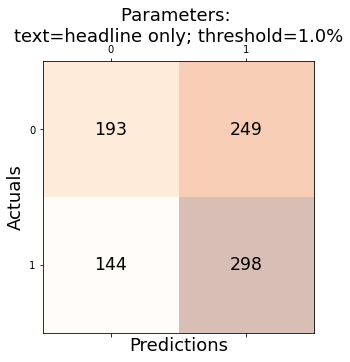

---
* Testset Accuracy: 0.5554298642533937
---
* Testset F1-Score: 0.60262891809909
---

###############################################################################################
* Best performing parameters: threshold=0.01; text_selection=headline
###############################################################################################

* 2021-09-20 1 at 0.0 %
* 2021-09-22 1 at 2.41 %
* 2021-10-15 0 at 0.0 %
* 2021-10-20 1 at 2.8 %
* 2021-10-21 2 at 3.06 %
* 2021-10-22 0 at 0.0 %
* 2021-10-25 0 at 0.0 %
* 2021-10-26 0 at 0.0 %
* 2021-10-27 1 at 0.53 %
* 2021-10-28 1 at -3.96 %
* 2021-10-29 0 at 0.0 %
* 2021-11-01 1 at -1.34 %
* 2021-11-03 0 at 0.0 %
* 2021-11-04 1 at -21.56 %
* 2021-11-05 0 at 0.0 %
* 2021-11-09 0 at 0.0 %
* 2021-11-10 0 at 0.0 %
* 2021-11-11 0 at 0.0 %
* 2021-11-12 1 at 0.15 %
* 2021-11-15 1 at -6.95 %
* 2021-11-16 0 at 0.0 %
* 2021-11-17 0 at 0.0 %
* 2021-11-19 1 at 0.25 %
* 2021-11-22 1 at 1.76 %
* 2021-11-23 1 at -5.42 %
* 2021-11-24 0 at 0.0 %
* 2021-

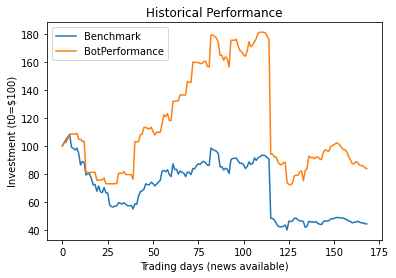


######################################################################

* 2021-09-20 0 at 0.0 %
* 2021-09-22 0 at 0.0 %
* 2021-10-15 0 at 0.0 %
* 2021-10-20 1 at 2.8 %
* 2021-10-21 2 at 3.06 %
* 2021-10-22 0 at 0.0 %
* 2021-10-25 0 at 0.0 %
* 2021-10-26 0 at 0.0 %
* 2021-10-27 1 at 0.53 %
* 2021-10-28 1 at -3.96 %
* 2021-10-29 0 at 0.0 %
* 2021-11-01 1 at -1.34 %
* 2021-11-03 0 at 0.0 %
* 2021-11-04 1 at -21.56 %
* 2021-11-05 0 at 0.0 %
* 2021-11-09 0 at 0.0 %
* 2021-11-10 0 at 0.0 %
* 2021-11-11 0 at 0.0 %
* 2021-11-12 0 at 0.0 %
* 2021-11-15 1 at -6.95 %
* 2021-11-16 0 at 0.0 %
* 2021-11-17 0 at 0.0 %
* 2021-11-19 1 at 0.25 %
* 2021-11-22 1 at 1.76 %
* 2021-11-23 1 at -5.42 %
* 2021-11-24 0 at 0.0 %
* 2021-11-26 0 at 0.0 %
* 2021-11-29 0 at 0.0 %
* 2021-12-01 0 at 0.0 %
* 2021-12-06 1 at 0.0 %
* 2021-12-07 2 at 0.41 %
* 2021-12-08 1 at 9.92 %
* 2021-12-09 0 at 0.0 %
* 2021-12-10 0 at 0.0 %
* 2021-12-13 1 at 1.45 %
* 2021-12-14 1 at -2.58 %
* 2021-12-15 0 at 0.0 %
* 2021-12-17 0 at 0

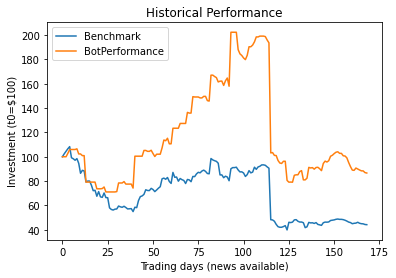


######################################################################



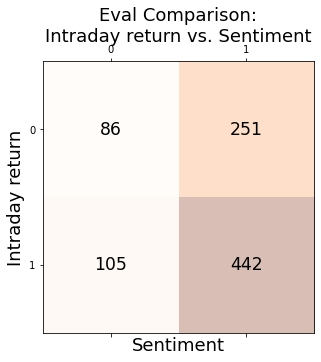



* Accuracy: 0.5972850678733032
* F1Score:  0.7129032258064515


In [ ]:
# Train configuration
trained_model, test_performance, testData, parameters = run_test_cycle([0.01], ['headline'], batch_size=32, epochs=3)

print("\n###############################################################################################")
print("* Best performing parameters: threshold=" + str(parameters[0]) + "; text_selection=" + str(parameters[1]))
print("###############################################################################################\n")

# Testset walkthrough played with exemplary $100
testset_walkthrough(trained_model, testData)

# Testset walkthrough including additional sentiment check
testset_walkthrough_incl_sentiment(trained_model, testData)

# Comparison to sentiment analysis
accuracy, f1score = comparison_to_sentiment_analysis(trained_model, testData)
print("\n")
print("* Accuracy:", accuracy)
print("* F1Score: ", f1score)


### Threshold = 1% / Text = Headline + Summary





###################################################################################################
###################################################################################################
###################################################################################################

* > 1.0%:  1890 / 5355
* _balanced:  1890 / 3780
DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 3024
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 378
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 378
    })
})


,sentence,label,idx
0,"Mitek Systems Non-GAAP EPS of $0.23 beats by $0.03, revenue of $39.3M beats by $3.31M. Mitek Systems press release (MITK): Q2 Non-GAAP EPS of $0.23 beats by $0.03.Revenue of $39.3M (+23.7% Y/Y) beats by $3.31M.",1,2475
1,"Rambus Inc. (RMBS) Q2 2022 Earnings Call Transcript | AlphaStreet. Rambus Inc. (NASDAQ: RMBS) Q2 2022 earnings call dated Aug. 01, 2022",1,1662
2,"Bluejay Diagnostics GAAP EPS of -$0.10, revenue of $249.04M. Bluejay Diagnostics press release (BJDX): Q2 GAAP EPS of -$0.10.Revenue of $249.04M.CEO comment: “Achievement of these milestones highlights Bluejay’s progression towards our goal…",0,2472
3,"Washington Trust Bancorp GAAP EPS of $1.14 beats by $0.23, revenue of $53.39M misses by $1.13M. No summary available.",1,121
4,"BrightSpire Capital Q2 2022 Earnings Preview (NYSE:BRSP). BrightSpire Capital (BRSP) is scheduled to announce Q2 earnings results on Wednesday, August 3rd, before market open.The consensus EPS Estimate is $0.23 (+253.3% Y/Y) and the…",0,927
5,"Codexis Q2 2022 Earnings Preview (NASDAQ:CDXS). Codexis (CDXS) is scheduled to announce Q2 earnings results on Thursday, August 4th, after market close.The consensus EPS Estimate is -$0.12 and the consensus Revenue Estimate is…",1,319
6,Ardmore Shipping Corporation PT Raised to $9 at Stifel. https://www.investing.com/news/pro/ardmore-shipping-corporation-pt-raised-to-9-at-stifel-432SI-2855713,0,154
7,"Tricon Capital FFO of $0.16 beats by $0.01, revenue of $99.85M (NYSE:TCN). Tricon Capital press release (NYSE:TCN): Q2 FFO of $0.16 beats by $0.01.Revenue of $99.85M (+21.9% Y/Y).",1,67
8,"Standard Motor Products Non-GAAP EPS of $0.86 misses by $0.32, revenue of $359.4M beats by $2.81M (NYSE:SMP). Standard Motor Products press release (SMP): Q2 Non-GAAP EPS of $0.86 misses by $0.32.Revenue of $359.4M (+5.1% Y/Y) beats by $2.81M.",0,1910
9,"Mr. Cooper Q2 2022 Earnings Preview (NASDAQ:COOP). Mr. Cooper (COOP) is scheduled to announce Q2 earnings results on Wednesday, July 27th, before market open.The consensus EPS Estimate is $0.03 (-99.4% Y/Y) and the consensus…",1,1034


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Columns added by tokenizer: ['attention_mask', 'input_ids']
* Model Checkpoint: distilbert-base-uncased


Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i



#########################################################


Epoch 1/3
94/94 [==============================] - ETA: 0s - loss: 0.6947 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


94/94 [==============================] - 1825s 19s/step - loss: 0.6947 - val_loss: 0.6896 - accuracy: 0.5455 - f1: 0.3162
Epoch 2/3
94/94 [==============================] - 1781s 19s/step - loss: 0.6872 - val_loss: 0.6790 - accuracy: 0.5341 - f1: 0.4605
Epoch 3/3
94/94 [==============================] - 1766s 19s/step - loss: 0.6593 - val_loss: 0.6860 - accuracy: 0.5540 - f1: 0.5722

#########################################################
threshold=0.01; text_selection=article
#########################################################



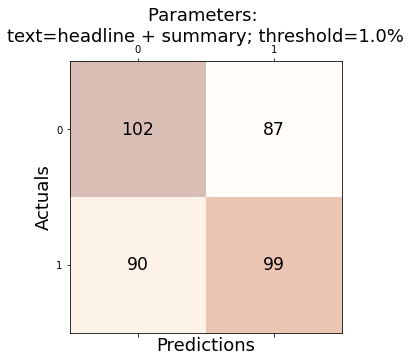

---
* Testset Accuracy: 0.5317460317460317
---
* Testset F1-Score: 0.5280000000000001
---

###############################################################################################
* Best performing parameters: threshold=0.01; text_selection=article
###############################################################################################

* 2021-10-12 0 at 0.0 %
* 2021-10-18 0 at 0.0 %
* 2021-10-19 1 at 4.08 %
* 2021-10-28 0 at 0.0 %
* 2021-11-01 0 at 0.0 %
* 2021-11-03 1 at -0.59 %
* 2021-11-04 0 at 0.0 %
* 2021-11-09 0 at 0.0 %
* 2021-11-12 0 at 0.0 %
* 2021-11-15 0 at 0.0 %
* 2021-11-16 0 at 0.0 %
* 2021-11-17 0 at 0.0 %
* 2021-11-18 0 at 0.0 %
* 2021-11-26 0 at 0.0 %
* 2021-12-17 0 at 0.0 %
* 2021-12-22 0 at 0.0 %
* 2021-12-23 0 at 0.0 %
* 2022-01-13 1 at 3.39 %
* 2022-01-14 0 at 0.0 %
* 2022-01-26 0 at 0.0 %
* 2022-01-31 1 at -3.31 %
* 2022-02-02 0 at 0.0 %
* 2022-02-07 0 at 0.0 %
* 2022-02-08 1 at 1.51 %
* 2022-02-09 0 at 0.0 %
* 2022-02-10 0 at 0.0 %
* 2022-02-18 1 a

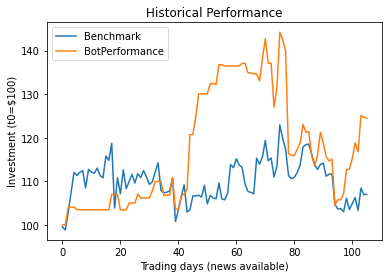


######################################################################

* 2021-10-12 0 at 0.0 %
* 2021-10-18 0 at 0.0 %
* 2021-10-19 1 at 4.08 %
* 2021-10-28 0 at 0.0 %
* 2021-11-01 0 at 0.0 %
* 2021-11-03 0 at 0.0 %
* 2021-11-04 0 at 0.0 %
* 2021-11-09 0 at 0.0 %
* 2021-11-12 0 at 0.0 %
* 2021-11-15 0 at 0.0 %
* 2021-11-16 0 at 0.0 %
* 2021-11-17 0 at 0.0 %
* 2021-11-18 0 at 0.0 %
* 2021-11-26 0 at 0.0 %
* 2021-12-17 0 at 0.0 %
* 2021-12-22 0 at 0.0 %
* 2021-12-23 0 at 0.0 %
* 2022-01-13 0 at 0.0 %
* 2022-01-14 0 at 0.0 %
* 2022-01-26 0 at 0.0 %
* 2022-01-31 0 at 0.0 %
* 2022-02-02 0 at 0.0 %
* 2022-02-07 0 at 0.0 %
* 2022-02-08 1 at 1.51 %
* 2022-02-09 0 at 0.0 %
* 2022-02-10 0 at 0.0 %
* 2022-02-18 1 at 1.97 %
* 2022-02-24 1 at -0.82 %
* 2022-03-09 0 at 0.0 %
* 2022-03-10 0 at 0.0 %
* 2022-03-24 0 at 0.0 %
* 2022-03-28 1 at 1.48 %
* 2022-03-30 0 at 0.0 %
* 2022-04-11 0 at 0.0 %
* 2022-04-12 0 at 0.0 %
* 2022-04-13 1 at -2.97 %
* 2022-04-14 1 at 0.1 %
* 2022-04-19 0 at 0.0 %
* 2022-

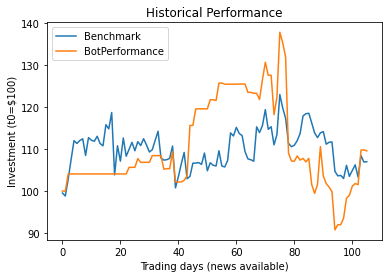


######################################################################



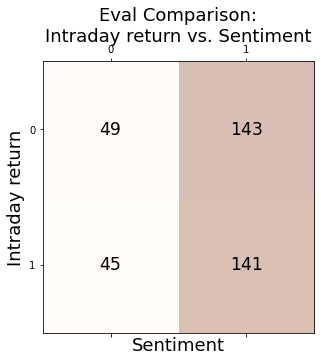



* Accuracy: 0.5026455026455027
* F1Score:  0.6


In [ ]:
# Train configuration
trained_model, test_performance, testData, parameters = run_test_cycle([0.01], ['article'], batch_size=32, epochs=3)

print("\n###############################################################################################")
print("* Best performing parameters: threshold=" + str(parameters[0]) + "; text_selection=" + str(parameters[1]))
print("###############################################################################################\n")

# Testset walkthrough played with exemplary $100
testset_walkthrough(trained_model, testData)

# Testset walkthrough including additional sentiment check
testset_walkthrough_incl_sentiment(trained_model, testData)

# Comparison to sentiment analysis
accuracy, f1score = comparison_to_sentiment_analysis(trained_model, testData)
print("\n")
print("* Accuracy:", accuracy)
print("* F1Score: ", f1score)


### Threshold = 3% / Text = Headline only





###################################################################################################
###################################################################################################
###################################################################################################

* > 3.0%:  2188 / 13193
* _balanced:  2188 / 4377
DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 3501
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 438
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 438
    })
})


,sentence,label,idx
0,"Short Interest in TSR, Inc. (NASDAQ:TSRI) Drops By 37.3%.",0,74
1,"Spirit of Texas Bancshares (NASDAQ:STXB) Downgraded by Keefe, Bruyette & Woods to Market Perform.",1,1236
2,"Right Now, Here’s How You Can Trade UWM Holdings Corporation (UWMC) Aggressively.",0,3042
3,Cherry Hill Mortgage Investment Corporation 8.250 CUM PFD B declares $0.5156 dividend.,1,3367
4,How is BX’s stock performing after recent trades?.,0,3050
5,Prelude Therapeutics Announces Second Quarter 2022 Financial Results and Business Update.,1,53
6,"Worthington raises dividend, boosting yield to above 3%.",0,780
7,"The Elmira Savings Bank GAAP EPS of $0.33, revenue of $5.09M.",0,164
8,American Electric Power Company – Consensus Indicates Potential 5.4% Upside.,0,1928
9,Dow Drops Over 100 Points; U.S. Trade Deficit Shrinks To This Level In June.,1,2485


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Columns added by tokenizer: ['attention_mask', 'input_ids']
* Model Checkpoint: distilbert-base-uncased


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_79', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i



#########################################################


Epoch 1/3
109/109 [==============================] - 1050s 10s/step - loss: 0.6790 - val_loss: 0.6530 - accuracy: 0.6082 - f1: 0.5935
Epoch 2/3
109/109 [==============================] - 1024s 9s/step - loss: 0.6330 - val_loss: 0.6525 - accuracy: 0.6082 - f1: 0.5810
Epoch 3/3
109/109 [==============================] - 1026s 9s/step - loss: 0.5803 - val_loss: 0.6612 - accuracy: 0.5986 - f1: 0.6014

#########################################################
threshold=0.03; text_selection=headline
#########################################################



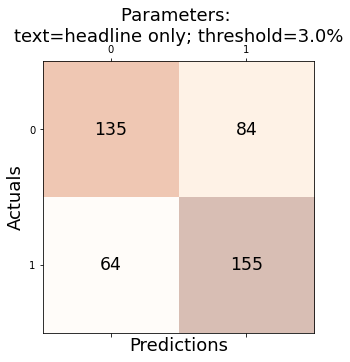

---
* Testset Accuracy: 0.6621004566210046
---
* Testset F1-Score: 0.6768558951965066
---

###############################################################################################
* Best performing parameters: threshold=0.03; text_selection=headline
###############################################################################################

* 2021-09-23 0 at 0.0 %
* 2021-09-24 0 at 0.0 %
* 2021-10-13 0 at 0.0 %
* 2021-10-20 0 at 0.0 %
* 2021-10-21 0 at 0.0 %
* 2021-10-28 0 at 0.0 %
* 2021-11-04 0 at 0.0 %
* 2021-11-05 1 at 10.0 %
* 2021-11-09 0 at 0.0 %
* 2021-11-11 0 at 0.0 %
* 2021-11-18 0 at 0.0 %
* 2021-11-19 0 at 0.0 %
* 2021-11-22 0 at 0.0 %
* 2021-11-24 0 at 0.0 %
* 2021-11-26 0 at 0.0 %
* 2021-11-29 1 at -0.46 %
* 2021-12-07 1 at 7.37 %
* 2021-12-08 0 at 0.0 %
* 2021-12-09 0 at 0.0 %
* 2021-12-10 0 at 0.0 %
* 2021-12-13 0 at 0.0 %
* 2021-12-14 0 at 0.0 %
* 2021-12-15 0 at 0.0 %
* 2021-12-16 0 at 0.0 %
* 2021-12-17 0 at 0.0 %
* 2021-12-20 1 at -16.36 %
* 2021-12-22 0 

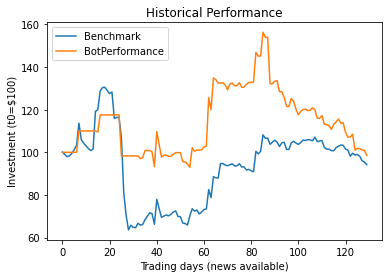


######################################################################

* 2021-09-23 0 at 0.0 %
* 2021-09-24 0 at 0.0 %
* 2021-10-13 0 at 0.0 %
* 2021-10-20 0 at 0.0 %
* 2021-10-21 0 at 0.0 %
* 2021-10-28 0 at 0.0 %
* 2021-11-04 0 at 0.0 %
* 2021-11-05 1 at 10.0 %
* 2021-11-09 0 at 0.0 %
* 2021-11-11 0 at 0.0 %
* 2021-11-18 0 at 0.0 %
* 2021-11-19 0 at 0.0 %
* 2021-11-22 0 at 0.0 %
* 2021-11-24 0 at 0.0 %
* 2021-11-26 0 at 0.0 %
* 2021-11-29 1 at -0.46 %
* 2021-12-07 1 at 7.37 %
* 2021-12-08 0 at 0.0 %
* 2021-12-09 0 at 0.0 %
* 2021-12-10 0 at 0.0 %
* 2021-12-13 0 at 0.0 %
* 2021-12-14 0 at 0.0 %
* 2021-12-15 0 at 0.0 %
* 2021-12-16 0 at 0.0 %
* 2021-12-17 0 at 0.0 %
* 2021-12-20 1 at -16.36 %
* 2021-12-22 0 at 0.0 %
* 2021-12-23 0 at 0.0 %
* 2021-12-31 0 at 0.0 %
* 2022-01-04 0 at 0.0 %
* 2022-01-05 0 at 0.0 %
* 2022-01-07 0 at 0.0 %
* 2022-01-10 0 at 0.0 %
* 2022-01-18 0 at 0.0 %
* 2022-01-19 0 at 0.0 %
* 2022-01-26 0 at 0.0 %
* 2022-02-03 0 at 0.0 %
* 2022-02-07 0 at 0.0 %
* 2022-0

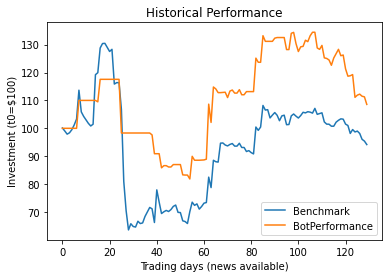


######################################################################



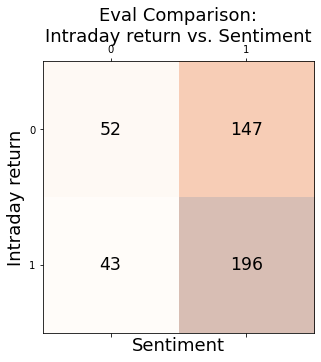



* Accuracy: 0.5662100456621004
* F1Score:  0.6735395189003437


In [ ]:
# Train configuration
trained_model, test_performance, testData, parameters = run_test_cycle([0.03], ['headline'], batch_size=32, epochs=3)

print("\n###############################################################################################")
print("* Best performing parameters: threshold=" + str(parameters[0]) + "; text_selection=" + str(parameters[1]))
print("###############################################################################################\n")

# Testset walkthrough played with exemplary $100
testset_walkthrough(trained_model, testData)

# Testset walkthrough including additional sentiment check
testset_walkthrough_incl_sentiment(trained_model, testData)

# Comparison to sentiment analysis
accuracy, f1score = comparison_to_sentiment_analysis(trained_model, testData)
print("\n")
print("* Accuracy:", accuracy)
print("* F1Score: ", f1score)


### Threshold = 3% / Text = Headline + Summary





###################################################################################################
###################################################################################################
###################################################################################################

* > 3.0%:  942 / 5355
* _balanced:  942 / 1885
DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1508
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 188
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 189
    })
})


,sentence,label,idx
0,"CNB Financial GAAP EPS of $0.84 beats by $0.09, revenue of $52.27M beats by $6.5M. CNB Financial press release (NASDAQ:CCNE): Q1 GAAP EPS of $0.84 beats by $0.09.Revenue of $52.27M (+10.4% Y/Y) beats by $6.5M.",1,1125
1,"Ramaco GAAP EPS of $0.74, revenue of $138.7M. Ramaco press release (NASDAQ:METC): Q2 GAAP EPS of $0.74.Revenue of $138.7M.",0,190
2,Hudson Global’s Financial Results Are Improving Rapidly In 2022. Hudson Global has a strong cash position and has reduced the number of shares by 12% since the end of 2018. See why I rate HSON stock as a speculative buy.,0,1362
3,"Keros Therapeutics (KROS) Investor Presentation - Slideshow (NASDAQ:KROS). The following slide deck was published by Keros Therapeutics, Inc.",0,264
4,"Trupanion, Inc. PT Lowered to $90 at Canaccord Genuity. https://www.investing.com/news/pro/trupanion-inc-pt-lowered-to-90-at-canaccord-genuity-432SI-2863617",1,409
5,Magnolia Oil & Gas declares $0.10 dividend (NYSE:MGY). Magnolia Oil & Gas (MGY) declares $0.10/share dividend. Payable Sept. 1; for shareholders of record Aug. 12; ex-div Aug. 11.,0,775
6,"Oblong Q2 revenue up Y/Y. Oblong press release (OBLG): Q2 net income of -$9.0M, compared to -$2.2M. Revenue of $1.3M (-36.3% Y/Y).Shares +3.13% AH.",1,1448
7,"Northern Lights Fund Trust Buys Xtrackers USD High Yield Corporate Bond ETF, SPDR Bloomberg .... Related Stocks: HYLB , SJNK ,",0,42
8,"Tecnoglass Q2 beats expectations, increases FY 2022 growth outlook. Tecnoglass press release (TGLS): Q2 Non-GAAP EPS of $0.69 beats by $0.12.Revenue of $169.1M (+38.9% Y/Y) beats by $20.02M.Record Single-Family Residential Revenues Increased…",1,641
9,Bristow Group Inc. 2023 Q1 - Results - Earnings Call Presentation (NYSE:VTOL). The following slide deck was published by Bristow Group Inc.,0,384


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Columns added by tokenizer: ['attention_mask', 'input_ids']
* Model Checkpoint: distilbert-base-uncased


Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i



#########################################################


Epoch 1/3
47/47 [==============================] - ETA: 0s - loss: 0.6940 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


47/47 [==============================] - 910s 19s/step - loss: 0.6940 - val_loss: 0.6794 - accuracy: 0.6000 - f1: 0.6235
Epoch 2/3
47/47 [==============================] - 882s 19s/step - loss: 0.6730 - val_loss: 0.6570 - accuracy: 0.6312 - f1: 0.6093
Epoch 3/3
47/47 [==============================] - 879s 19s/step - loss: 0.6426 - val_loss: 0.6565 - accuracy: 0.6312 - f1: 0.6144

#########################################################
threshold=0.03; text_selection=article
#########################################################



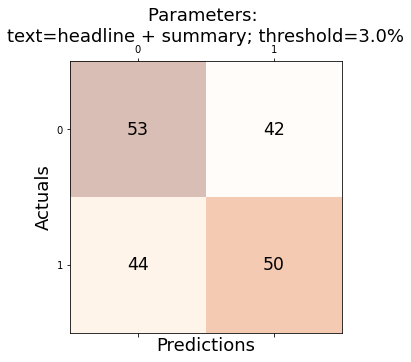

---
* Testset Accuracy: 0.544973544973545
---
* Testset F1-Score: 0.5376344086021505
---

###############################################################################################
* Best performing parameters: threshold=0.03; text_selection=article
###############################################################################################

* 2021-10-21 0 at 0.0 %
* 2021-11-16 0 at 0.0 %
* 2021-12-07 1 at 2.66 %
* 2021-12-15 1 at -1.15 %
* 2022-01-24 1 at 0.69 %
* 2022-01-26 1 at -3.97 %
* 2022-02-07 0 at 0.0 %
* 2022-02-16 1 at -7.47 %
* 2022-02-25 1 at 1.97 %
* 2022-03-01 0 at 0.0 %
* 2022-03-03 1 at 3.5 %
* 2022-03-10 1 at -0.06 %
* 2022-03-11 0 at 0.0 %
* 2022-03-21 0 at 0.0 %
* 2022-04-01 0 at 0.0 %
* 2022-04-11 0 at 0.0 %
* 2022-04-21 0 at 0.0 %
* 2022-04-28 0 at 0.0 %
* 2022-05-12 2 at -0.08 %
* 2022-05-16 2 at 0.78 %
* 2022-05-19 2 at 1.31 %
* 2022-05-24 1 at -3.42 %
* 2022-05-25 0 at 0.0 %
* 2022-05-26 1 at 7.32 %
* 2022-06-01 0 at 0.0 %
* 2022-06-02 1 at -0.7 %
* 202

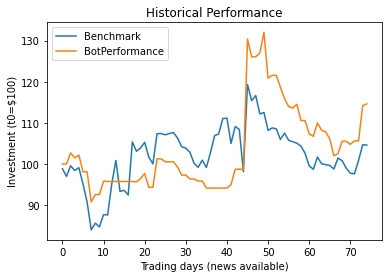


######################################################################

* 2021-10-21 0 at 0.0 %
* 2021-11-16 0 at 0.0 %
* 2021-12-07 1 at 2.66 %
* 2021-12-15 1 at -1.15 %
* 2022-01-24 0 at 0.0 %
* 2022-01-26 1 at -3.97 %
* 2022-02-07 0 at 0.0 %
* 2022-02-16 1 at -7.47 %
* 2022-02-25 1 at 1.97 %
* 2022-03-01 0 at 0.0 %
* 2022-03-03 1 at 3.5 %
* 2022-03-10 1 at -0.06 %
* 2022-03-11 0 at 0.0 %
* 2022-03-21 0 at 0.0 %
* 2022-04-01 0 at 0.0 %
* 2022-04-11 0 at 0.0 %
* 2022-04-21 0 at 0.0 %
* 2022-04-28 0 at 0.0 %
* 2022-05-12 1 at 0.29 %
* 2022-05-16 2 at 0.78 %
* 2022-05-19 2 at 1.31 %
* 2022-05-24 1 at -3.42 %
* 2022-05-25 0 at 0.0 %
* 2022-05-26 1 at 7.32 %
* 2022-06-01 0 at 0.0 %
* 2022-06-02 1 at -0.7 %
* 2022-06-03 0 at 0.0 %
* 2022-06-07 0 at 0.0 %
* 2022-06-09 0 at 0.0 %
* 2022-06-13 0 at 0.0 %
* 2022-06-14 0 at 0.0 %
* 2022-06-22 2 at -0.98 %
* 2022-06-23 0 at 0.0 %
* 2022-06-24 1 at -0.51 %
* 2022-06-28 0 at 0.0 %
* 2022-06-29 0 at 0.0 %
* 2022-07-06 0 at 0.0 %
* 2022-07-07 0 at 

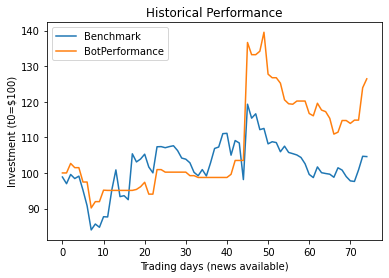


######################################################################



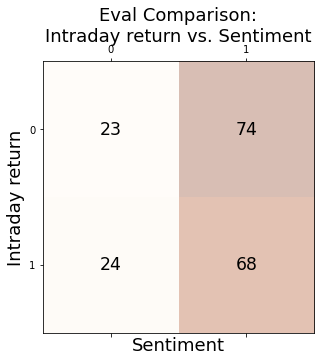



* Accuracy: 0.48148148148148145
* F1Score:  0.5811965811965811


In [ ]:
# Train configuration
trained_model, test_performance, testData, parameters = run_test_cycle([0.03], ['article'], batch_size=32, epochs=3)

print("\n###############################################################################################")
print("* Best performing parameters: threshold=" + str(parameters[0]) + "; text_selection=" + str(parameters[1]))
print("###############################################################################################\n")

# Testset walkthrough played with exemplary $100
testset_walkthrough(trained_model, testData)

# Testset walkthrough including additional sentiment check
testset_walkthrough_incl_sentiment(trained_model, testData)

# Comparison to sentiment analysis
accuracy, f1score = comparison_to_sentiment_analysis(trained_model, testData)
print("\n")
print("* Accuracy:", accuracy)
print("* F1Score: ", f1score)


### Threshold = -1% / Text = Headline





###################################################################################################
###################################################################################################
###################################################################################################

* > -1.0%:  8908 / 13193
DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 10554
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1319
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1320
    })
})


,sentence,label,idx
0,MediaAlpha Announces Second Quarter 2022 Financial Results.,0,3119
1,Cherry Hill: 16.07% Dividend With Significant Upside Potential (NYSE:CHMI).,1,2970
2,Oil prices slide after report Saudi Arabia could step up if Russian output dips under sanctions.,1,1102
3,Marathon Oil Corporation (NYSE: MRO): Unlocking Growth Opportunity.,1,9082
4,"Signify Health leads healthcare gainers; Pharvaris, Assure Holdings among major losers.",1,2580
5,Arrowhead Pharmaceuticals Reports Fiscal 2022 Third Quarter Results.,1,3177
6,Do investors need to be concerned about Sesen Bio Inc. (SESN)?.,1,10259
7,Do investors need to be concerned about Diebold Nixdorf Incorporated (DBD)?.,1,3649
8,"Delighting stocks: TD Holdings, Inc. (NASDAQ:GLG 0.56%), OncoCyte Corporation (NASDAQ:OCX 13.60%).",1,7337
9,"RadNet AI-based software solutions for breast, prostate cancers gets FDA clearance.",1,1620


  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Columns added by tokenizer: ['attention_mask', 'input_ids']
* Model Checkpoint: distilbert-base-uncased


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use i



#########################################################


Epoch 1/3
329/329 [==============================] - 3234s 10s/step - loss: 0.6254 - val_loss: 0.6170 - accuracy: 0.6761 - f1: 0.8067
Epoch 2/3
329/329 [==============================] - 3246s 10s/step - loss: 0.6059 - val_loss: 0.6080 - accuracy: 0.6814 - f1: 0.8039
Epoch 3/3
329/329 [==============================] - 3244s 10s/step - loss: 0.5669 - val_loss: 0.6188 - accuracy: 0.6692 - f1: 0.7839

#########################################################
threshold=-0.01; text_selection=headline
#########################################################



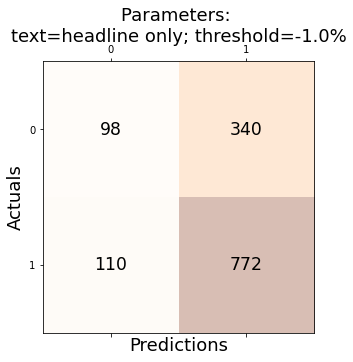

---
* Testset Accuracy: 0.6590909090909091
---
* Testset F1-Score: 0.7743229689067203
---

###############################################################################################
* Best performing parameters: threshold=-0.01; text_selection=headline
###############################################################################################

* 2021-09-22 1 at 0.23 %
* 2021-10-07 1 at -1.47 %
* 2021-10-13 1 at -0.85 %
* 2021-10-15 1 at -1.49 %
* 2021-10-20 4 at 0.0 %
* 2021-10-21 1 at 2.17 %
* 2021-10-22 2 at 3.05 %
* 2021-10-25 1 at 2.81 %
* 2021-10-27 1 at 1.0 %
* 2021-10-28 1 at -0.78 %
* 2021-10-29 2 at -4.36 %
* 2021-11-01 3 at -1.07 %
* 2021-11-03 1 at -1.3 %
* 2021-11-05 4 at -3.08 %
* 2021-11-09 1 at 5.08 %
* 2021-11-11 5 at -2.16 %
* 2021-11-12 8 at -0.5 %
* 2021-11-15 1 at 4.08 %
* 2021-11-16 4 at -0.01 %
* 2021-11-17 7 at 1.17 %
* 2021-11-18 1 at -0.97 %
* 2021-11-19 5 at 1.39 %
* 2021-11-22 5 at -3.24 %
* 2021-11-23 2 at -9.41 %
* 2021-11-24 2 at -0.33 %
* 2021-11

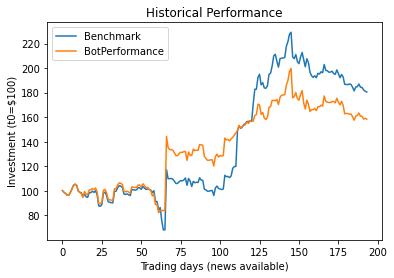


######################################################################

* 2021-09-22 1 at 0.23 %
* 2021-10-07 1 at -1.47 %
* 2021-10-13 1 at -0.85 %
* 2021-10-15 1 at -1.49 %
* 2021-10-20 4 at 0.0 %
* 2021-10-21 1 at 2.17 %
* 2021-10-22 1 at 0.51 %
* 2021-10-25 0 at 0.0 %
* 2021-10-27 0 at 0.0 %
* 2021-10-28 1 at -0.78 %
* 2021-10-29 2 at -4.36 %
* 2021-11-01 2 at -1.5 %
* 2021-11-03 1 at -1.3 %
* 2021-11-05 3 at -4.78 %
* 2021-11-09 1 at 5.08 %
* 2021-11-11 5 at -2.16 %
* 2021-11-12 7 at 0.4 %
* 2021-11-15 1 at 4.08 %
* 2021-11-16 4 at -0.01 %
* 2021-11-17 6 at 1.43 %
* 2021-11-18 0 at 0.0 %
* 2021-11-19 3 at 1.24 %
* 2021-11-22 4 at -3.97 %
* 2021-11-23 1 at -5.87 %
* 2021-11-24 1 at -0.66 %
* 2021-11-26 3 at 1.52 %
* 2021-11-29 0 at 0.0 %
* 2021-11-30 2 at 1.34 %
* 2021-12-01 4 at -3.5 %
* 2021-12-02 2 at 1.62 %
* 2021-12-03 2 at -0.62 %
* 2021-12-06 4 at -0.19 %
* 2021-12-07 5 at -0.05 %
* 2021-12-08 0 at 0.0 %
* 2021-12-09 4 at 0.27 %
* 2021-12-10 4 at 5.53 %
* 2021-12-13 3 at 2.

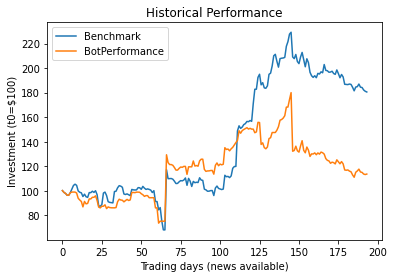


######################################################################



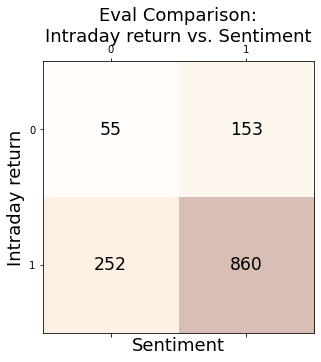



* Accuracy: 0.6931818181818182
* F1Score:  0.8094117647058823


In [ ]:
# Train configuration
trained_model, test_performance, testData, parameters = run_test_cycle([-0.01], ['headline'], batch_size=32, epochs=3)

print("\n###############################################################################################")
print("* Best performing parameters: threshold=" + str(parameters[0]) + "; text_selection=" + str(parameters[1]))
print("###############################################################################################\n")

# Testset walkthrough played with exemplary $100
testset_walkthrough(trained_model, testData)

# Testset walkthrough including additional sentiment check
testset_walkthrough_incl_sentiment(trained_model, testData)

# Comparison to sentiment analysis
accuracy, f1score = comparison_to_sentiment_analysis(trained_model, testData)
print("\n")
print("* Accuracy:", accuracy)
print("* F1Score: ", f1score)


### Threshold = -1% / Text = Headline + Summary





###################################################################################################
###################################################################################################
###################################################################################################

* > -1.0%:  3541 / 5355
DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 4284
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 535
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 536
    })
})


,sentence,label,idx
0,"Affiliated Managers Group, Inc. 2022 Q2 - Results - Earnings Call Presentation (NYSE:AMG). The following slide deck was published by Affiliated Managers Group, Inc.",1,1825
1,IDE Water Technologies Celebrates the Successful Launch of Bonaires New Desalination Plant in Partnership with WEB Bonaire.,0,2289
2,"ProPhase Labs Q2 2022 Earnings Preview. ProPhase Labs (PRPH) is scheduled to announce Q2 earnings results on Thursday, August 11th, before market open.The consensus EPS Estimate is $0.16 and the consensus Revenue Estimate…",1,1905
3,"Franklin Street Properties (FSP) Q2 2022 Earnings Call Transcript. FSP earnings call for the period ending June 30, 2022.",0,856
4,Maxeon Solar Technologies Ltd. PT Raised to $22 at Roth Capital. https://www.investing.com/news/pro/maxeon-solar-technologies-ltd-pt-raised-to-22-at-roth-capital-432SI-2876227,0,1368
5,"Mirati: A Potential Blockbuster Stock, Will Need Patience (NASDAQ:MRTX). Mirati has strong competitive differences against larger rival Amgen. However, lead indication, 2nd line NSCLC, is not where these differences will come out.",1,2094
6,"HireRight Holdings Non-GAAP EPS of $0.54 beats by $0.20, revenue of $222.3M beats by $22.18M. HireRight Holdings press release (HRT): Q2 Non-GAAP EPS of $0.54 beats by $0.20.Revenue of $222.3M beats by $22.18M.Shares +3.4% AH.",1,3401
7,"Ballard Power to help develop India''s first hydrogen-powered trains. Ballard Power Systems (BLDP) +2.9% pre-market on Tuesday after saying it won a fuel cell module order from India-based rail system integrator Medha Servo Drives, which has been…",1,1230
8,Inari Medical Stock: Growth Set To Reaccelerate In Back Half. Shares of Inari are down 25% year to date and Covid limited its ability to develop the DVT market. Click here to read the full analysis of NARI stock.,1,780
9,"FNCB Bancorp GAAP EPS of $0.29, revenue of $15.28M. FNCB Bancorp press release (NASDAQ:FNCB): Q2 GAAP EPS of $0.29.Revenue of $15.28M (+11.2% Y/Y).",1,1830


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Columns added by tokenizer: ['input_ids', 'attention_mask']
* Model Checkpoint: distilbert-base-uncased


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use i



#########################################################


Epoch 1/3
133/133 [==============================] - 2654s 20s/step - loss: 0.6421 - val_loss: 0.6196 - accuracy: 0.6602 - f1: 0.7953
Epoch 2/3
133/133 [==============================] - 2622s 20s/step - loss: 0.6236 - val_loss: 0.6163 - accuracy: 0.6719 - f1: 0.8009
Epoch 3/3
133/133 [==============================] - 2568s 19s/step - loss: 0.5870 - val_loss: 0.6199 - accuracy: 0.6582 - f1: 0.7863

#########################################################
threshold=-0.01; text_selection=article
#########################################################



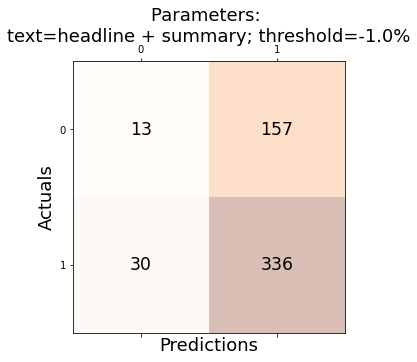

---
* Testset Accuracy: 0.6511194029850746
---
* Testset F1-Score: 0.7823050058207218
---

###############################################################################################
* Best performing parameters: threshold=-0.01; text_selection=article
###############################################################################################

* 2021-10-18 1 at 0.02 %
* 2021-11-01 1 at -4.6 %
* 2021-11-04 1 at 2.42 %
* 2021-11-12 2 at 1.08 %
* 2021-11-15 1 at -1.33 %
* 2021-11-17 1 at 3.5 %
* 2021-12-02 1 at -0.63 %
* 2021-12-14 1 at 1.99 %
* 2021-12-22 2 at -1.75 %
* 2022-01-13 1 at 2.55 %
* 2022-01-19 1 at -2.95 %
* 2022-01-24 1 at 5.14 %
* 2022-01-26 2 at 4.37 %
* 2022-01-28 1 at 0.14 %
* 2022-01-31 2 at 2.29 %
* 2022-02-07 1 at -2.17 %
* 2022-02-09 3 at -4.22 %
* 2022-02-10 1 at -0.17 %
* 2022-02-14 1 at 0.88 %
* 2022-02-18 2 at -0.14 %
* 2022-02-28 1 at 0.69 %
* 2022-03-01 0 at 0.0 %
* 2022-03-02 1 at -1.03 %
* 2022-03-17 2 at -3.18 %
* 2022-03-21 1 at 0.22 %
* 2022-03-22 

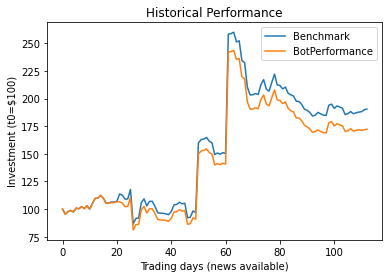


######################################################################

* 2021-10-18 1 at 0.02 %
* 2021-11-01 1 at -4.6 %
* 2021-11-04 1 at 2.42 %
* 2021-11-12 2 at 1.08 %
* 2021-11-15 1 at -1.33 %
* 2021-11-17 1 at 3.5 %
* 2021-12-02 1 at -0.63 %
* 2021-12-14 1 at 1.99 %
* 2021-12-22 1 at -3.37 %
* 2022-01-13 1 at 2.55 %
* 2022-01-19 0 at 0.0 %
* 2022-01-24 1 at 5.14 %
* 2022-01-26 2 at 4.37 %
* 2022-01-28 1 at 0.14 %
* 2022-01-31 1 at 5.08 %
* 2022-02-07 0 at 0.0 %
* 2022-02-09 2 at -3.95 %
* 2022-02-10 1 at -0.17 %
* 2022-02-14 1 at 0.88 %
* 2022-02-18 2 at -0.14 %
* 2022-02-28 1 at 0.69 %
* 2022-03-01 0 at 0.0 %
* 2022-03-02 1 at -1.03 %
* 2022-03-17 1 at -3.99 %
* 2022-03-21 1 at 0.22 %
* 2022-03-22 2 at 7.87 %
* 2022-03-23 1 at -26.52 %
* 2022-03-31 1 at 5.81 %
* 2022-04-01 2 at 0.34 %
* 2022-04-04 1 at 15.27 %
* 2022-04-13 2 at 3.11 %
* 2022-04-14 1 at 0.79 %
* 2022-04-20 1 at 3.98 %
* 2022-04-21 0 at 0.0 %
* 2022-04-22 0 at 0.0 %
* 2022-04-25 2 at -5.61 %
* 2022-04-26 1 at -0.

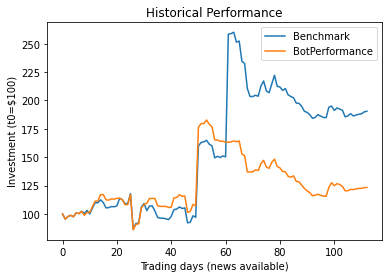


######################################################################



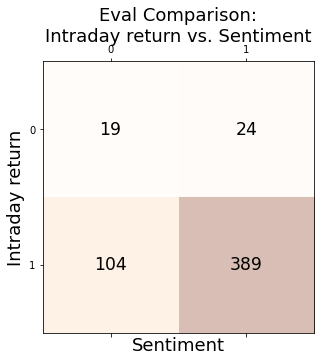



* Accuracy: 0.7611940298507462
* F1Score:  0.8587196467991169


In [ ]:
# Train configuration
trained_model, test_performance, testData, parameters = run_test_cycle([-0.01], ['article'], batch_size=32, epochs=3)

print("\n###############################################################################################")
print("* Best performing parameters: threshold=" + str(parameters[0]) + "; text_selection=" + str(parameters[1]))
print("###############################################################################################\n")

# Testset walkthrough played with exemplary $100
testset_walkthrough(trained_model, testData)

# Testset walkthrough including additional sentiment check
testset_walkthrough_incl_sentiment(trained_model, testData)

# Comparison to sentiment analysis
accuracy, f1score = comparison_to_sentiment_analysis(trained_model, testData)
print("\n")
print("* Accuracy:", accuracy)
print("* F1Score: ", f1score)
